In [7]:
#Calculate the mean and standard deviation of the dataset

from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, ToTensor, Compose
from torch.utils.data import DataLoader
from tqdm import tqdm

dataset_path = '/mnt/eds_share/share/Spine2D/GlobusSrgMapData_crop_square/train/'
# dataset_path = '/mnt/eds_share/share/Body_Parts_XRay/Original/train/'
# Define the transform
transform = Compose([
    Resize((224, 224)),  # Resize all images to 512x512
    ToTensor()
])

# Create the dataset with the transform
dataset = ImageFolder(root=dataset_path, transform=transform)

# Create the DataLoader with the transformed dataset
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=0)

# Compute the mean and standard deviation
mean = 0.
std = 0.
for images, _ in tqdm(dataloader):
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

mean /= len(dataloader.dataset)
std /= len(dataloader.dataset)

print(mean, std) #tensor([0.4233, 0.4233, 0.4233]) tensor([0.2114, 0.2114, 0.2114])

 35%|███▌      | 429/1217 [05:54<13:22,  1.02s/it]/opt/miniconda/envs/yz_openclip1/lib/python3.11/site-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (91393600 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 35%|███▌      | 430/1217 [05:56<16:24,  1.25s/it]/opt/miniconda/envs/yz_openclip1/lib/python3.11/site-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (94633984 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/miniconda/envs/yz_openclip1/lib/python3.11/site-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (95160025 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/miniconda/envs/yz_openclip1/lib/python3.11/site-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (94090000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warning

tensor([0.3942, 0.3942, 0.3942]) tensor([0.2378, 0.2378, 0.2378])


In [8]:
print(mean, std)

tensor([0.3942, 0.3942, 0.3942]) tensor([0.2378, 0.2378, 0.2378])


In [6]:
from PIL import Image
import os
import numpy as np
from tqdm import tqdm

def compute_dataset_stats(image_folder):
    all_means = []
    all_stds = []

    # Iterate over all images in the folder
    for fname in tqdm(os.listdir(image_folder)):
        image_path = os.path.join(image_folder, fname)
        
        # Open image and convert to grayscale
        img = Image.open(image_path).convert('RGB') #.convert('L')
        img_np = np.array(img)
        
        # Compute mean and standard deviation for the image
        img_mean = img_np.mean()
        img_std = img_np.std()
        
        all_means.append(img_mean)
        all_stds.append(img_std)
    
    # Compute overall mean and standard deviation for the dataset
    overall_mean = np.mean(all_means)
    overall_std = np.mean(all_stds)

    return overall_mean, overall_std

# image_folder = '/mnt/eds_share/share/Spine2D/GlobusSrgMapData_crop_square/train/'
image_folder = '/mnt/eds_share/share/Body_Parts_XRay/Original/train/images'
mean, std = compute_dataset_stats(image_folder)
print(f"Mean: {mean}, Standard Deviation: {std}") 
# Mean: 89.24861701751402, Standard Deviation: 65.85327891219714 for Body_Parts_XRay
# 0.3942, 0.3942, 0.3942 for Spine2D-Mean
# 0.2378, 0.2378, 0.2378 for Spine2D-Std


100%|██████████| 1390/1390 [00:05<00:00, 277.90it/s]

Mean: 89.24861701751402, Standard Deviation: 65.85327891219714


In [ ]:
# https://github.com/mlfoundations/open_clip/issues/439

#Code to implement data augmentation: --aug-cfg scale='(0.33, 1.0)' re_prob=0.35
"""
A.Affine(rotate=(-15, 15), translate_percent=(0.0, 0.25), shear=(-3, 3), p=0.5),
A.RandomResizedCrop(image_size[0], image_size[1], scale=(0.9, 1.0), ratio=(0.75, 1.3333333333)),
A.ToGray(p=0.1),
A.GaussianBlur(blur_limit=(3, 7), p=0.05),
A.GaussNoise(p=0.05),
A.RandomGridShuffle(grid=(2, 2), p=0.3),
A.Posterize(p=0.2),
A.RandomBrightnessContrast(p=0.5),
A.Cutout(p=0.05),
A.RandomSnow(p=0.1),
A.RandomRain(p=0.05),
A.HorizontalFlip(p=0.5),
"""

from torchvision.transforms import Normalize, Compose, RandomResizedCrop, InterpolationMode, ToTensor, Resize, CenterCrop

def _convert_to_rgb(image):
    return image.convert('RGB')
normalize = Normalize(mean=mean, std=std)
train_transform = Compose([
    RandomResizedCrop(
        image_size,
        scale=aug_cfg_dict.pop('scale'),
        interpolation=InterpolationMode.BICUBIC,
    ),
    _convert_to_rgb,
    ToTensor(),
    normalize,
])

In [40]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.transforms import functional as F
from torchvision.transforms import (Normalize, Compose, RandomResizedCrop, RandomRotation, 
                                   RandomHorizontalFlip, ColorJitter, RandomAffine, 
                                   GaussianBlur, RandomCrop, RandomErasing, InterpolationMode, 
                                   ToTensor, Resize, CenterCrop, Lambda)
import random, torch


class AlbumentationsTransform:
    def __init__(self, transform=None):
        self.transform = transform

    def __call__(self, img):
        img = F.to_tensor(img).numpy() * 255  # Convert to numpy array in range [0, 255]
        img = img.transpose(1, 2, 0)  # Convert from CxHxW to HxWxC
        img = self.transform(image=img)['image']
        img = F.to_pil_image(img.astype('uint8'))  # Convert back to PIL image
        return img


class AlbumentationsTransform2:
    def __init__(self, transform=None):
        self.transform = transform

    def __call__(self, img):
        img = np.array(img)  # Convert to numpy array
        img = self.transform(image=img)['image']
        return Image.fromarray(img)  # Convert back to PIL image


class RandomAugmentation:
    def __init__(self, probability, *transforms):
        self.probability = probability
        self.transforms = transforms

    def __call__(self, img):
        if random.random() <= self.probability:
            for transform in self.transforms:
                img = transform(img)
        return img

# Define the CLAHE transformation
clahe = A.CLAHE(p=1.0, clip_limit=6.0, tile_grid_size=(12, 12))

# Define the mean and standard deviation of the dataset
MEAN = (0.3942, 0.3942, 0.3942)#(0.48145466, 0.4578275, 0.40821073)
STD = (0.2378, 0.2378, 0.2378)#(0.26862954, 0.26130258, 0.27577711)
image_size = (224,224)

def _convert_to_rgb(image):
    return image.convert('RGB')

# Albumentations transformations
albu_transforms = A.Compose([
    # A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),  # Elastic deformation
    # A.HistogramMatching(p=0.5, reference_images=None),  # Histogram Equalization (note: you need reference images)
    # Add any other albumentations transforms here
    A.GaussianBlur(p=0.3, blur_limit=(3, 5))
])

# torchvision transforms
pre_rotation = Compose([
    RandomRotation(degrees=15),
])

pre_resize = Compose([
    RandomResizedCrop(
        image_size,
        scale=(0.9, 1.1),
        interpolation=InterpolationMode.BICUBIC,
    ),
])

pre_transforms = Compose([
    RandomHorizontalFlip(p=0.5),
    ColorJitter(brightness=0.15, contrast=0.15),
    RandomAffine(degrees=0, translate=(0.1, 0.1)),
    RandomCrop(size=image_size, padding=10),
    # GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),
])

post_transforms = Compose([
    _convert_to_rgb,
    ToTensor(),
    # RandomErasing(p=0.2, scale=(0.01, 0.05), ratio=(0.3, 3.3), value=0, inplace=False),  # Cutout or Random Erasing
])

train_transform = Compose([
    AlbumentationsTransform2(clahe),
    # RandomAugmentation(0.3, pre_rotation),
    pre_resize,
    # 0.3 means 30% of images will be augmented
    # RandomAugmentation(0.3, pre_transforms, AlbumentationsTransform(albu_transforms)),
    # AlbumentationsTransform2(clahe),
    post_transforms
])

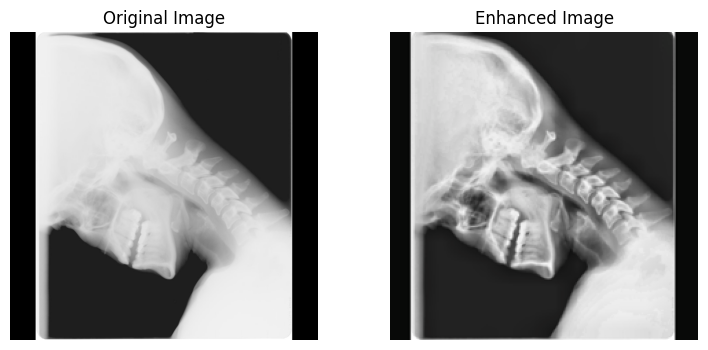

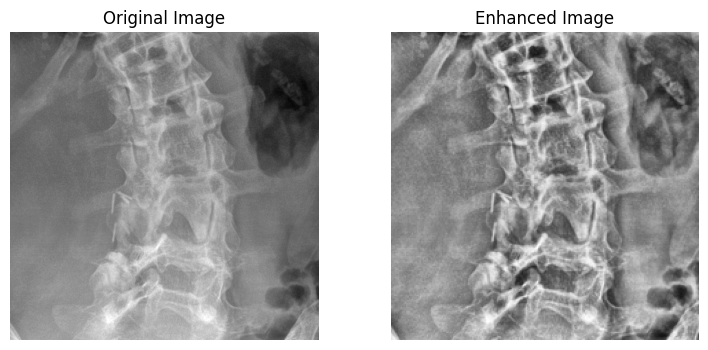

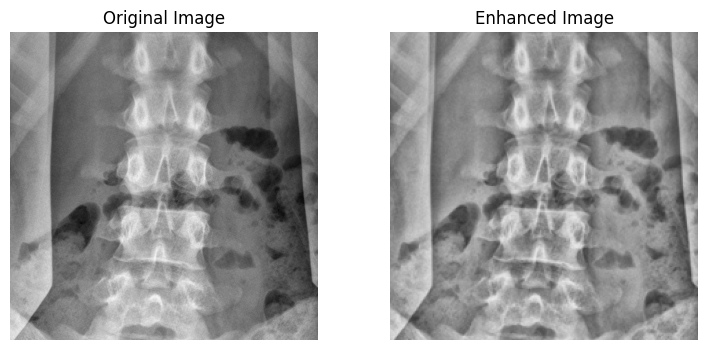

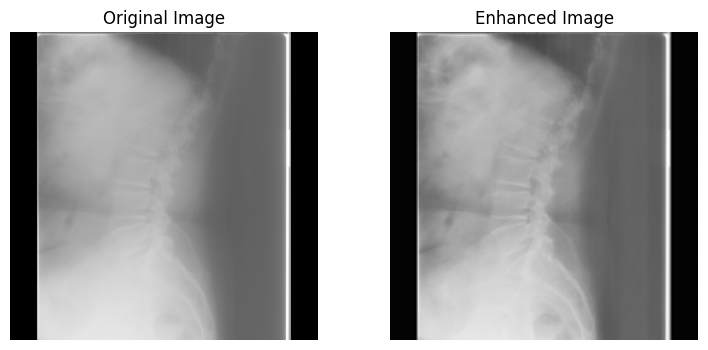

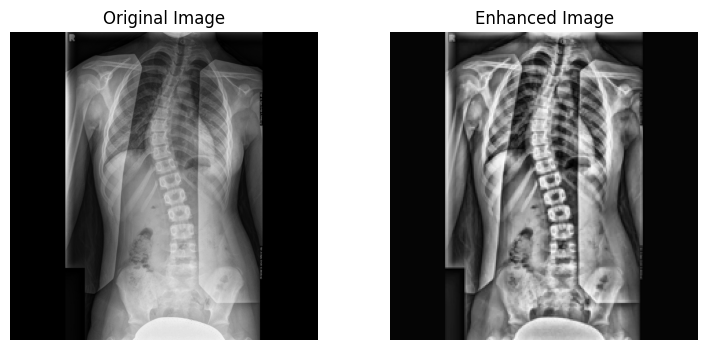

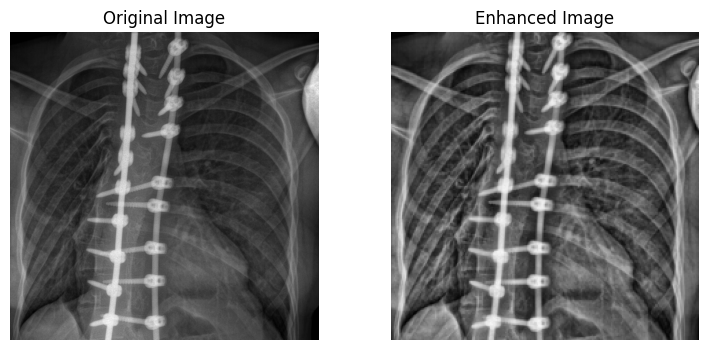

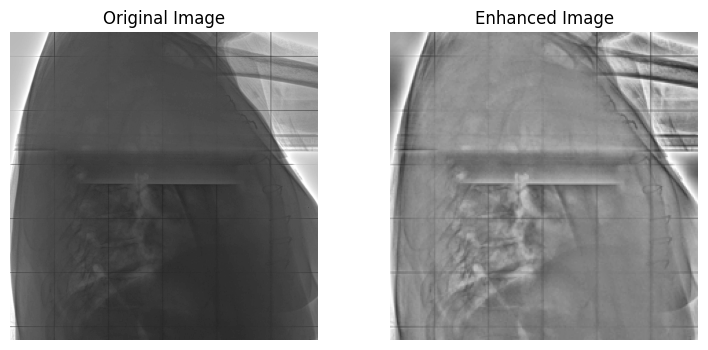

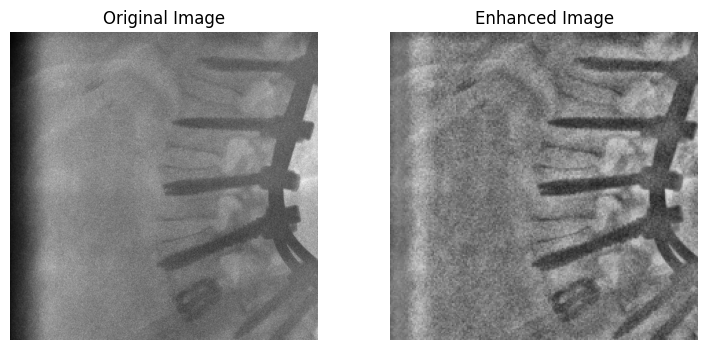

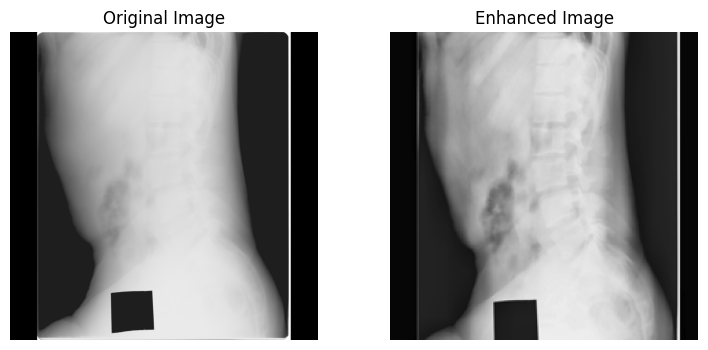

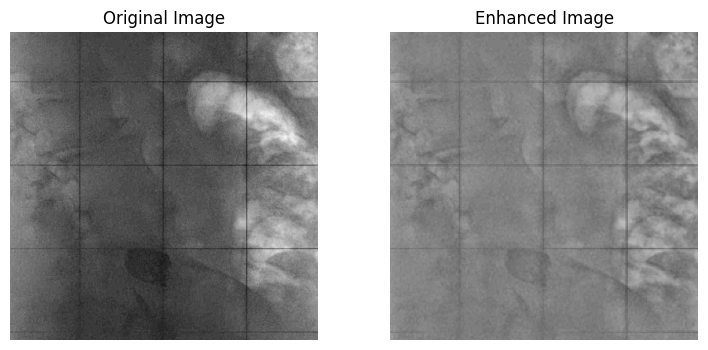

In [41]:
"""
To visualize the augmentation on a few images, you can follow the steps below:

Load a few images.
Apply the transformation pipeline train_transform to each image.
Display the original and augmented images side by side using matplotlib.

Remember to change path_to_your_images to the directory where your images are located. 
The code will display the original and augmented images side by side for the first five images in the directory. 
This will allow you to inspect the effects of your augmentation pipeline.
"""
import os, random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pandas as pd
from torchvision.transforms import ToPILImage
to_pil = ToPILImage()

def visualize_augmentations(original_img, augmented_img):
    fig, ax = plt.subplots(1, 2, figsize=(9, 4))
    ax[0].imshow(original_img, cmap="gray") #
    ax[0].set_title("Original Image")
    ax[1].imshow(augmented_img, cmap="gray")
    ax[1].set_title("Enhanced Image")
    for a in ax:
        a.axis("off")
    plt.show()

# def visualize_augmentations(original_img, augmented_img, histogram_original, histogram_augmented):
#     fig, ax = plt.subplots(2, 2, figsize=(6, 6))
    
#     ax[0, 0].imshow(original_img, cmap="gray")
#     ax[0, 0].set_title("Original Image")
    
#     ax[0, 1].imshow(augmented_img, cmap="gray")
#     ax[0, 1].set_title("Augmented Image")
    
#     ax[1, 0].hist(histogram_original, bins=256, range=(0,256), density=True, color='gray', alpha=0.7)
#     ax[1, 0].set_xlabel('Pixel Intensity')
#     ax[1, 0].set_ylabel('Frequency')
#     ax[1, 0].set_title('Histogram of Original Image')
    
#     ax[1, 1].hist(histogram_augmented, bins=256, range=(0,256), density=True, color='gray', alpha=0.7)
#     ax[1, 1].set_xlabel('Pixel Intensity')
#     ax[1, 1].set_ylabel('Frequency')
#     ax[1, 1].set_title('Histogram of Augmented Image')

       
#     for a in ax.ravel():
#         a.axis("off")
#     # Enable axis for histogram
#     ax[1, 0].axis("on")
#     ax[1, 1].axis("on")   
    
    
#     plt.tight_layout()
#     plt.show()


# Load a few images
# image_folder = '/mnt/eds_share/share/Body_Parts_XRay/images/train/'
image_folder = '/mnt/eds_share/share/Spine2D/GlobusSrgMapData_crop_square/train/images/'
sample_images = [os.path.join(image_folder, fname) for fname in os.listdir(image_folder)]
# Set the random seed
random.seed(42)
sample_images = random.sample(sample_images, 10)

for image_path in sample_images:
    original_img = Image.open(image_path)
    # print(np.array(original_img).max()/255., np.array(original_img).min()/255.)
    augmented_img = train_transform(original_img)
    # print(np.array(augmented_img).max(), np.array(augmented_img).min())
    augmented_img = augmented_img.permute(1, 2, 0)  # Convert CxHxW to HxWxC for visualization
    # print(augmented_img.shape)
    
    #histogram for original image
    image = original_img.convert('L')
    # Convert the image to a numpy array
    histogram_original = np.array(image).ravel()
    
    #histogram for augmented image
    augmented_img_permuted = augmented_img.permute(2, 0, 1)
    augmented_img_pil = to_pil(augmented_img_permuted)
    augmented_img_gray = augmented_img_pil.convert('L')
    # Convert the image to a numpy array
    histogram_augmented = np.array(augmented_img_gray).ravel()
    
    # visualize_augmentations(original_img, augmented_img, histogram_original, histogram_augmented)
    visualize_augmentations(original_img, augmented_img)
    